In [125]:
# import libraries

import pandas as pd 
import numpy as np

from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Read datasets

tumor = pd.read_csv("./data/20250203_GBMFOV_tumorcelltable.csv")
immune = pd.read_csv("data/20250203_GBMFOV_immunecelltable.csv")

print(tumor.shape, immune.shape)

(90328, 48) (90355, 57)


In [127]:
tumor.columns

Index(['cellid', 'ApoE', 'Au', 'B7H3', 'CD133', 'CD14', 'CD163', 'CD31',
       'CD3e', 'CD4', 'CD45', 'CD47', 'CD70', 'CD8a', 'EGFR', 'EGFRvIII',
       'EphA2', 'FOXP3', 'Fe', 'GD2', 'GFAP', 'GM2_GD2', 'GPC2', 'H3K27M',
       'H3K27me3', 'HER2', 'HLA1', 'HLADR', 'IDH1_R132H', 'IL13RA2', 'Ki67',
       'NG2', 'NeuN', 'Noodle', 'Nuclear', 'Olig2', 'TMEM119', 'VISTA',
       'YAP_TAZ', 'area', 'major_axis_length', 'minor_axis_length',
       'perimeter', 'convex_area', 'equivalent_diameter', 'centroid.0',
       'centroid.1', 'fov'],
      dtype='object')

In [128]:
#set cell_id as index
tumor = tumor.set_index("cellid")
immune = immune.set_index("cellid")

# Extract metacols fov, centroid.0, centroid.1
tumor_meta = tumor[["fov","centroid.0","centroid.1"]]
immune_meta = immune[["fov","centroid.0","centroid.1"]]

# Drop columns not needed
tumor_data = tumor.drop(columns=["fov","centroid.0","centroid.1"])
immune_data = immune.drop(columns=[ "fov","centroid.0","centroid.1"])

In [129]:
# sanity check
print(tumor_data.shape, immune_data.shape)

(90328, 44) (90355, 53)


In [130]:
# Min-max normalization
tumor_data = (tumor_data - tumor_data.min()) / (tumor_data.max() - tumor_data.min())
immune_data = (immune_data - immune_data.min()) / (immune_data.max() - immune_data.min())

In [131]:
# Check the columns that are the same 
common_cols = list(set(tumor_data.columns).intersection(set(immune_data.columns)))

# Print the columns present in df1 but not in df2
tumor_only = list(set(tumor_data.columns) - set(immune_data.columns))

# Print the columns present in df2 but not in df1
immune_only = list(set(immune_data.columns) - set(tumor_data.columns))

print("num_common_cols", len(common_cols))
print("num_tumor_only", len(tumor_only))
print("num_immune_only", len(immune_only))


num_common_cols 24
num_tumor_only 20
num_immune_only 29


In [132]:
print(common_cols)
print(tumor_only)
print(immune_only)

['CD47', 'CD45', 'CD4', 'perimeter', 'convex_area', 'equivalent_diameter', 'Olig2', 'CD133', 'NeuN', 'Noodle', 'Au', 'major_axis_length', 'area', 'Fe', 'Ki67', 'HLA1', 'HLADR', 'GFAP', 'Nuclear', 'CD163', 'CD31', 'CD14', 'TMEM119', 'minor_axis_length']
['GM2_GD2', 'H3K27M', 'FOXP3', 'HER2', 'ApoE', 'VISTA', 'CD8a', 'GPC2', 'YAP_TAZ', 'NG2', 'EphA2', 'CD70', 'IDH1_R132H', 'B7H3', 'EGFR', 'IL13RA2', 'GD2', 'CD3e', 'H3K27me3', 'EGFRvIII']
['chan_70', 'CD141', 'FoxP3', 'PDL1', 'Calprotectin', 'CD40', 'chan_39', 'chan_48', 'CD8', 'IDO1', 'CD20', 'CD209', 'Arginase1', 'PD1', 'CD68', 'ICOS', 'CD11b', 'Tox', 'CD206', 'iNOS', 'CD38', 'CD3', 'TIM3', 'CD86', 'CD208', 'GLUT1', 'LAG3', 'CD123', 'Chym_Tryp']


## Strategy 1
- Train 2 individual methods that would predict from the common markers 

In [134]:
# Split the X and y data
# X is all the columns that are common between the two dataframes
# y is the columns that are only in the immune_data
X = immune_data[common_cols]
y = immune_data[immune_only]

print(X.shape, y.shape)

(90355, 24) (90355, 29)


In [135]:
# Prep the second section data
X2 = tumor_data[common_cols]
y2 = tumor_data[tumor_only]

print(X2.shape, y2.shape)

(90328, 24) (90328, 20)


In [136]:
# Split the immune data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [137]:
# print the shapes for all
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(57827, 24) (57827, 29)
(14457, 24) (14457, 29)
(18071, 24) (18071, 29)


### Manual 

marker name: chan_70
[0]	validation_0-rmse:0.00586
[1]	validation_0-rmse:0.00557
[2]	validation_0-rmse:0.00532
[3]	validation_0-rmse:0.00512
[4]	validation_0-rmse:0.00495
[5]	validation_0-rmse:0.00481
[6]	validation_0-rmse:0.00471
[7]	validation_0-rmse:0.00460
[8]	validation_0-rmse:0.00452
[9]	validation_0-rmse:0.00445
[10]	validation_0-rmse:0.00438
[11]	validation_0-rmse:0.00433
[12]	validation_0-rmse:0.00425
[13]	validation_0-rmse:0.00423
[14]	validation_0-rmse:0.00422
[15]	validation_0-rmse:0.00421
[16]	validation_0-rmse:0.00419
[17]	validation_0-rmse:0.00419
[18]	validation_0-rmse:0.00417
[19]	validation_0-rmse:0.00417
[20]	validation_0-rmse:0.00417
[21]	validation_0-rmse:0.00416
[22]	validation_0-rmse:0.00416
[23]	validation_0-rmse:0.00415
[24]	validation_0-rmse:0.00414
[25]	validation_0-rmse:0.00415
[26]	validation_0-rmse:0.00415
[27]	validation_0-rmse:0.00416
[28]	validation_0-rmse:0.00416
[29]	validation_0-rmse:0.00416
[30]	validation_0-rmse:0.00417
[31]	validation_0-rmse:0.004

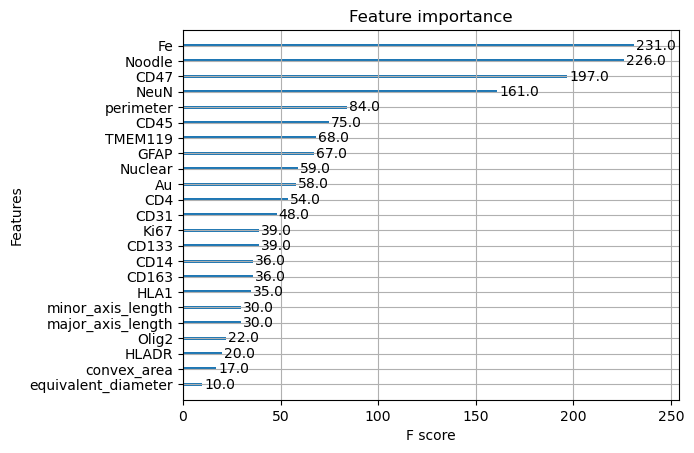

marker name: CD141
[0]	validation_0-rmse:0.01364
[1]	validation_0-rmse:0.01323
[2]	validation_0-rmse:0.01287
[3]	validation_0-rmse:0.01258
[4]	validation_0-rmse:0.01229
[5]	validation_0-rmse:0.01209
[6]	validation_0-rmse:0.01189
[7]	validation_0-rmse:0.01175
[8]	validation_0-rmse:0.01164
[9]	validation_0-rmse:0.01152
[10]	validation_0-rmse:0.01145
[11]	validation_0-rmse:0.01140
[12]	validation_0-rmse:0.01136
[13]	validation_0-rmse:0.01133
[14]	validation_0-rmse:0.01128
[15]	validation_0-rmse:0.01124
[16]	validation_0-rmse:0.01120
[17]	validation_0-rmse:0.01117
[18]	validation_0-rmse:0.01115
[19]	validation_0-rmse:0.01114
[20]	validation_0-rmse:0.01113
[21]	validation_0-rmse:0.01110
[22]	validation_0-rmse:0.01109
[23]	validation_0-rmse:0.01108
[24]	validation_0-rmse:0.01107
[25]	validation_0-rmse:0.01104
[26]	validation_0-rmse:0.01103
[27]	validation_0-rmse:0.01101
[28]	validation_0-rmse:0.01101
[29]	validation_0-rmse:0.01099
[30]	validation_0-rmse:0.01099
[31]	validation_0-rmse:0.01098

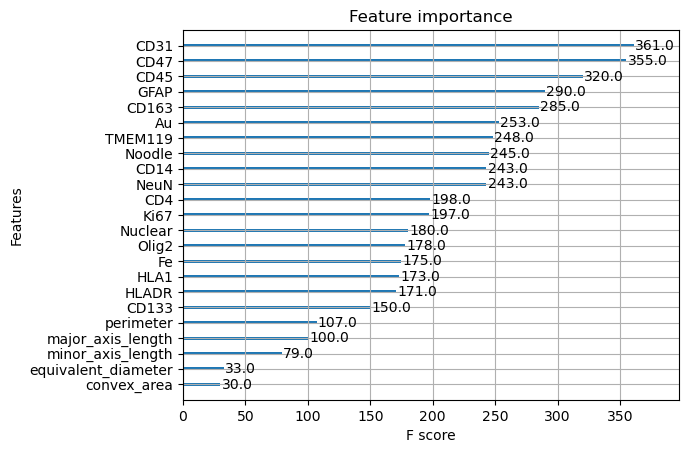

marker name: FoxP3
[0]	validation_0-rmse:0.03202
[1]	validation_0-rmse:0.03019
[2]	validation_0-rmse:0.02862
[3]	validation_0-rmse:0.02724
[4]	validation_0-rmse:0.02603
[5]	validation_0-rmse:0.02501
[6]	validation_0-rmse:0.02412
[7]	validation_0-rmse:0.02331
[8]	validation_0-rmse:0.02264
[9]	validation_0-rmse:0.02208
[10]	validation_0-rmse:0.02157
[11]	validation_0-rmse:0.02113
[12]	validation_0-rmse:0.02077
[13]	validation_0-rmse:0.02045
[14]	validation_0-rmse:0.02018
[15]	validation_0-rmse:0.01996
[16]	validation_0-rmse:0.01975
[17]	validation_0-rmse:0.01958
[18]	validation_0-rmse:0.01943
[19]	validation_0-rmse:0.01930
[20]	validation_0-rmse:0.01917
[21]	validation_0-rmse:0.01906
[22]	validation_0-rmse:0.01899
[23]	validation_0-rmse:0.01895
[24]	validation_0-rmse:0.01887
[25]	validation_0-rmse:0.01881
[26]	validation_0-rmse:0.01877
[27]	validation_0-rmse:0.01871
[28]	validation_0-rmse:0.01867
[29]	validation_0-rmse:0.01865
[30]	validation_0-rmse:0.01861
[31]	validation_0-rmse:0.01858

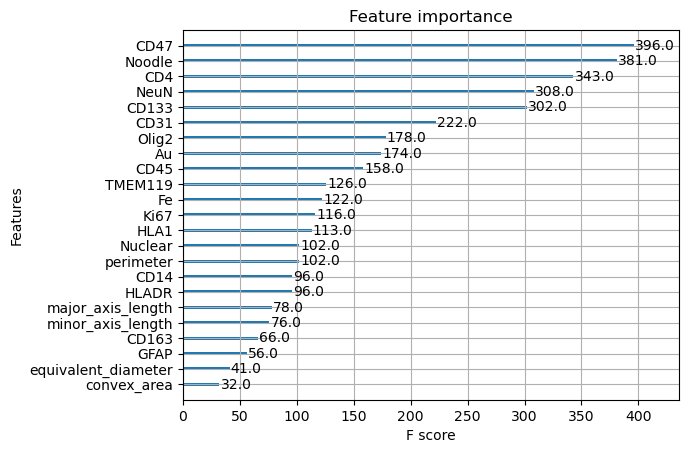

marker name: PDL1
[0]	validation_0-rmse:0.01704
[1]	validation_0-rmse:0.01677
[2]	validation_0-rmse:0.01653
[3]	validation_0-rmse:0.01634
[4]	validation_0-rmse:0.01616
[5]	validation_0-rmse:0.01603
[6]	validation_0-rmse:0.01590
[7]	validation_0-rmse:0.01579
[8]	validation_0-rmse:0.01570
[9]	validation_0-rmse:0.01564
[10]	validation_0-rmse:0.01556
[11]	validation_0-rmse:0.01551
[12]	validation_0-rmse:0.01546
[13]	validation_0-rmse:0.01542
[14]	validation_0-rmse:0.01538
[15]	validation_0-rmse:0.01535
[16]	validation_0-rmse:0.01531
[17]	validation_0-rmse:0.01529
[18]	validation_0-rmse:0.01526
[19]	validation_0-rmse:0.01524
[20]	validation_0-rmse:0.01522
[21]	validation_0-rmse:0.01520
[22]	validation_0-rmse:0.01519
[23]	validation_0-rmse:0.01517
[24]	validation_0-rmse:0.01517
[25]	validation_0-rmse:0.01514
[26]	validation_0-rmse:0.01514
[27]	validation_0-rmse:0.01512
[28]	validation_0-rmse:0.01511
[29]	validation_0-rmse:0.01510
[30]	validation_0-rmse:0.01508
[31]	validation_0-rmse:0.01508


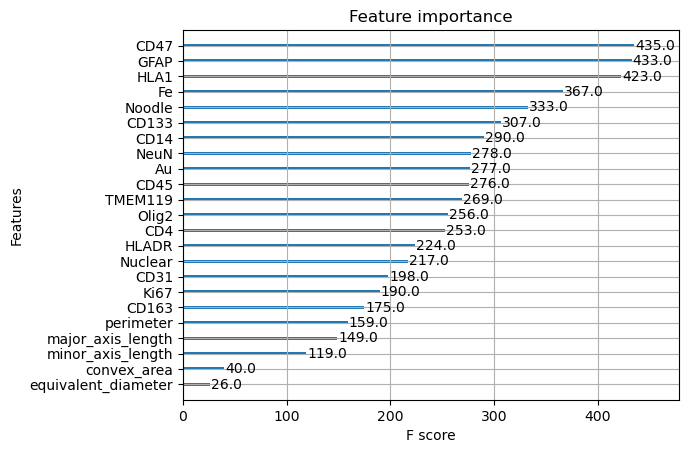

marker name: Calprotectin
[0]	validation_0-rmse:0.01555
[1]	validation_0-rmse:0.01483
[2]	validation_0-rmse:0.01419
[3]	validation_0-rmse:0.01363
[4]	validation_0-rmse:0.01320
[5]	validation_0-rmse:0.01284
[6]	validation_0-rmse:0.01254
[7]	validation_0-rmse:0.01226
[8]	validation_0-rmse:0.01198
[9]	validation_0-rmse:0.01177
[10]	validation_0-rmse:0.01157
[11]	validation_0-rmse:0.01147
[12]	validation_0-rmse:0.01134
[13]	validation_0-rmse:0.01129
[14]	validation_0-rmse:0.01124
[15]	validation_0-rmse:0.01122
[16]	validation_0-rmse:0.01115
[17]	validation_0-rmse:0.01112
[18]	validation_0-rmse:0.01111
[19]	validation_0-rmse:0.01108
[20]	validation_0-rmse:0.01104
[21]	validation_0-rmse:0.01106
[22]	validation_0-rmse:0.01103
[23]	validation_0-rmse:0.01103
[24]	validation_0-rmse:0.01102
[25]	validation_0-rmse:0.01102
[26]	validation_0-rmse:0.01101
[27]	validation_0-rmse:0.01102
[28]	validation_0-rmse:0.01100
[29]	validation_0-rmse:0.01097
[30]	validation_0-rmse:0.01097
[31]	validation_0-rmse:

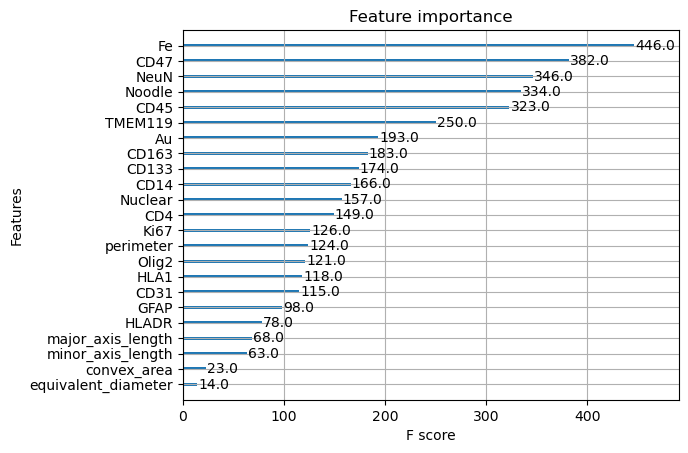

marker name: CD40
[0]	validation_0-rmse:0.01199
[1]	validation_0-rmse:0.01154
[2]	validation_0-rmse:0.01113
[3]	validation_0-rmse:0.01077
[4]	validation_0-rmse:0.01046
[5]	validation_0-rmse:0.01029
[6]	validation_0-rmse:0.01015
[7]	validation_0-rmse:0.00998
[8]	validation_0-rmse:0.00986
[9]	validation_0-rmse:0.00975
[10]	validation_0-rmse:0.00966
[11]	validation_0-rmse:0.00958
[12]	validation_0-rmse:0.00950
[13]	validation_0-rmse:0.00945
[14]	validation_0-rmse:0.00938
[15]	validation_0-rmse:0.00933
[16]	validation_0-rmse:0.00930
[17]	validation_0-rmse:0.00928
[18]	validation_0-rmse:0.00926
[19]	validation_0-rmse:0.00923
[20]	validation_0-rmse:0.00921
[21]	validation_0-rmse:0.00919
[22]	validation_0-rmse:0.00915
[23]	validation_0-rmse:0.00914
[24]	validation_0-rmse:0.00913
[25]	validation_0-rmse:0.00911
[26]	validation_0-rmse:0.00908
[27]	validation_0-rmse:0.00907
[28]	validation_0-rmse:0.00904
[29]	validation_0-rmse:0.00903
[30]	validation_0-rmse:0.00901
[31]	validation_0-rmse:0.00898


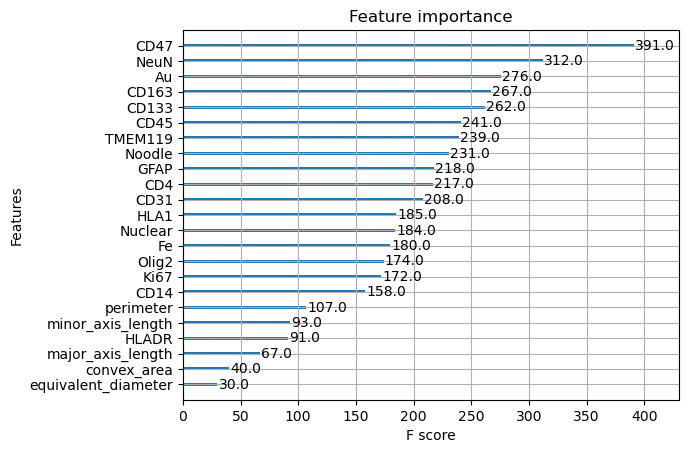

marker name: chan_39
[0]	validation_0-rmse:0.00783
[1]	validation_0-rmse:0.00769
[2]	validation_0-rmse:0.00763
[3]	validation_0-rmse:0.00756
[4]	validation_0-rmse:0.00749
[5]	validation_0-rmse:0.00739
[6]	validation_0-rmse:0.00736
[7]	validation_0-rmse:0.00729
[8]	validation_0-rmse:0.00724
[9]	validation_0-rmse:0.00720
[10]	validation_0-rmse:0.00716
[11]	validation_0-rmse:0.00714
[12]	validation_0-rmse:0.00712
[13]	validation_0-rmse:0.00710
[14]	validation_0-rmse:0.00709
[15]	validation_0-rmse:0.00704
[16]	validation_0-rmse:0.00700
[17]	validation_0-rmse:0.00698
[18]	validation_0-rmse:0.00696
[19]	validation_0-rmse:0.00694
[20]	validation_0-rmse:0.00692
[21]	validation_0-rmse:0.00691
[22]	validation_0-rmse:0.00687
[23]	validation_0-rmse:0.00686
[24]	validation_0-rmse:0.00684
[25]	validation_0-rmse:0.00675
[26]	validation_0-rmse:0.00667
[27]	validation_0-rmse:0.00667
[28]	validation_0-rmse:0.00666
[29]	validation_0-rmse:0.00663
[30]	validation_0-rmse:0.00662
[31]	validation_0-rmse:0.006

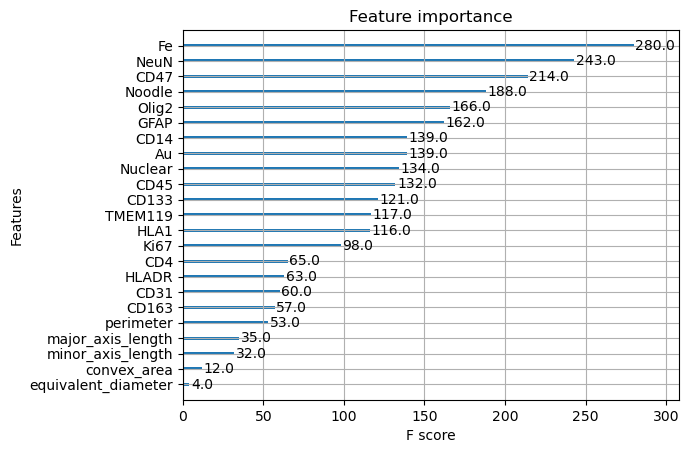

marker name: chan_48
[0]	validation_0-rmse:0.01130
[1]	validation_0-rmse:0.01121
[2]	validation_0-rmse:0.01113
[3]	validation_0-rmse:0.01105
[4]	validation_0-rmse:0.01097
[5]	validation_0-rmse:0.01090
[6]	validation_0-rmse:0.01082
[7]	validation_0-rmse:0.01078
[8]	validation_0-rmse:0.01072
[9]	validation_0-rmse:0.01067
[10]	validation_0-rmse:0.01062
[11]	validation_0-rmse:0.01061
[12]	validation_0-rmse:0.01060
[13]	validation_0-rmse:0.01059
[14]	validation_0-rmse:0.01058
[15]	validation_0-rmse:0.01056
[16]	validation_0-rmse:0.01054
[17]	validation_0-rmse:0.01053
[18]	validation_0-rmse:0.01053
[19]	validation_0-rmse:0.01052
[20]	validation_0-rmse:0.01051
[21]	validation_0-rmse:0.01050
[22]	validation_0-rmse:0.01050
[23]	validation_0-rmse:0.01053
[24]	validation_0-rmse:0.01053
[25]	validation_0-rmse:0.01053
[26]	validation_0-rmse:0.01051
[27]	validation_0-rmse:0.01049
[28]	validation_0-rmse:0.01048
[29]	validation_0-rmse:0.01048
[30]	validation_0-rmse:0.01047
[31]	validation_0-rmse:0.010

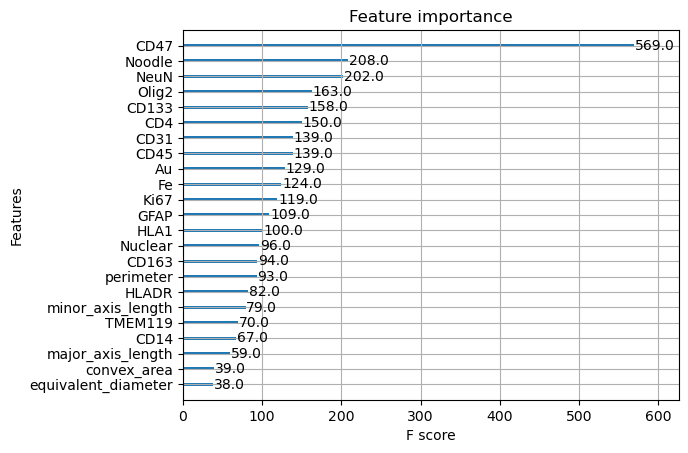

marker name: CD8
[0]	validation_0-rmse:0.01325
[1]	validation_0-rmse:0.01276
[2]	validation_0-rmse:0.01219
[3]	validation_0-rmse:0.01177
[4]	validation_0-rmse:0.01149
[5]	validation_0-rmse:0.01119
[6]	validation_0-rmse:0.01098
[7]	validation_0-rmse:0.01079
[8]	validation_0-rmse:0.01058
[9]	validation_0-rmse:0.01027
[10]	validation_0-rmse:0.01016
[11]	validation_0-rmse:0.01000
[12]	validation_0-rmse:0.00998
[13]	validation_0-rmse:0.00981
[14]	validation_0-rmse:0.00972
[15]	validation_0-rmse:0.00968
[16]	validation_0-rmse:0.00966
[17]	validation_0-rmse:0.00960
[18]	validation_0-rmse:0.00958
[19]	validation_0-rmse:0.00957
[20]	validation_0-rmse:0.00950
[21]	validation_0-rmse:0.00949
[22]	validation_0-rmse:0.00949
[23]	validation_0-rmse:0.00950
[24]	validation_0-rmse:0.00947
[25]	validation_0-rmse:0.00949
[26]	validation_0-rmse:0.00946
[27]	validation_0-rmse:0.00947
[28]	validation_0-rmse:0.00947
[29]	validation_0-rmse:0.00948
[30]	validation_0-rmse:0.00950
[31]	validation_0-rmse:0.00951
[

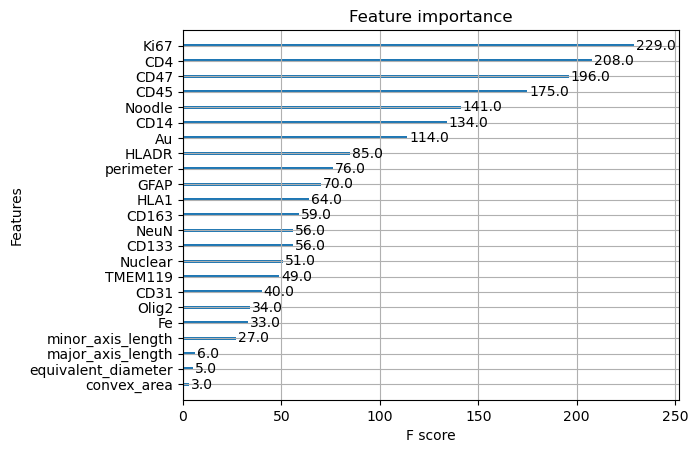

marker name: IDO1
[0]	validation_0-rmse:0.01687
[1]	validation_0-rmse:0.01661
[2]	validation_0-rmse:0.01637
[3]	validation_0-rmse:0.01614
[4]	validation_0-rmse:0.01596
[5]	validation_0-rmse:0.01581
[6]	validation_0-rmse:0.01568
[7]	validation_0-rmse:0.01557
[8]	validation_0-rmse:0.01550
[9]	validation_0-rmse:0.01538
[10]	validation_0-rmse:0.01530
[11]	validation_0-rmse:0.01525
[12]	validation_0-rmse:0.01520
[13]	validation_0-rmse:0.01514
[14]	validation_0-rmse:0.01511
[15]	validation_0-rmse:0.01507
[16]	validation_0-rmse:0.01501
[17]	validation_0-rmse:0.01497
[18]	validation_0-rmse:0.01497
[19]	validation_0-rmse:0.01495
[20]	validation_0-rmse:0.01493
[21]	validation_0-rmse:0.01490
[22]	validation_0-rmse:0.01490
[23]	validation_0-rmse:0.01489
[24]	validation_0-rmse:0.01490
[25]	validation_0-rmse:0.01489
[26]	validation_0-rmse:0.01487
[27]	validation_0-rmse:0.01487
[28]	validation_0-rmse:0.01485
[29]	validation_0-rmse:0.01483
[30]	validation_0-rmse:0.01482
[31]	validation_0-rmse:0.01481


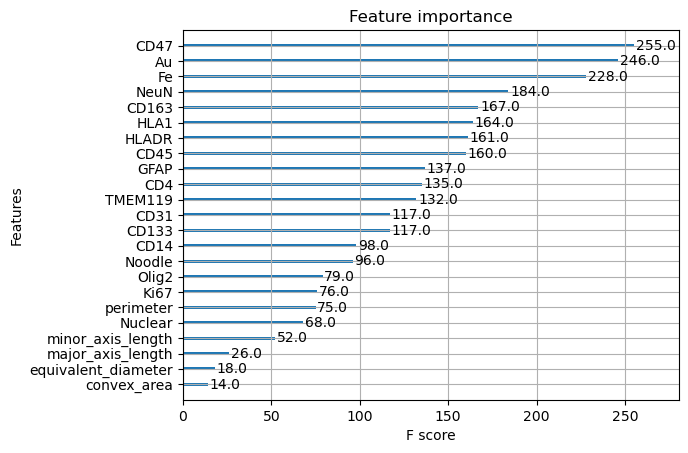

marker name: CD20
[0]	validation_0-rmse:0.01494
[1]	validation_0-rmse:0.01453
[2]	validation_0-rmse:0.01420
[3]	validation_0-rmse:0.01391
[4]	validation_0-rmse:0.01365
[5]	validation_0-rmse:0.01344
[6]	validation_0-rmse:0.01327
[7]	validation_0-rmse:0.01311
[8]	validation_0-rmse:0.01296
[9]	validation_0-rmse:0.01283
[10]	validation_0-rmse:0.01273
[11]	validation_0-rmse:0.01267
[12]	validation_0-rmse:0.01259
[13]	validation_0-rmse:0.01254
[14]	validation_0-rmse:0.01245
[15]	validation_0-rmse:0.01240
[16]	validation_0-rmse:0.01236
[17]	validation_0-rmse:0.01233
[18]	validation_0-rmse:0.01231
[19]	validation_0-rmse:0.01227
[20]	validation_0-rmse:0.01225
[21]	validation_0-rmse:0.01224
[22]	validation_0-rmse:0.01222
[23]	validation_0-rmse:0.01220
[24]	validation_0-rmse:0.01219
[25]	validation_0-rmse:0.01217
[26]	validation_0-rmse:0.01215
[27]	validation_0-rmse:0.01214
[28]	validation_0-rmse:0.01213
[29]	validation_0-rmse:0.01212
[30]	validation_0-rmse:0.01211
[31]	validation_0-rmse:0.01210


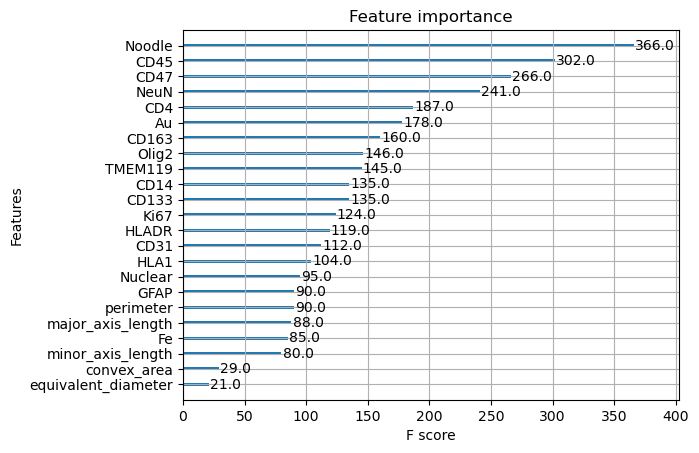

marker name: CD209
[0]	validation_0-rmse:0.01907
[1]	validation_0-rmse:0.01848
[2]	validation_0-rmse:0.01790
[3]	validation_0-rmse:0.01751
[4]	validation_0-rmse:0.01716
[5]	validation_0-rmse:0.01683
[6]	validation_0-rmse:0.01661
[7]	validation_0-rmse:0.01640
[8]	validation_0-rmse:0.01621
[9]	validation_0-rmse:0.01608
[10]	validation_0-rmse:0.01592
[11]	validation_0-rmse:0.01583
[12]	validation_0-rmse:0.01573
[13]	validation_0-rmse:0.01563
[14]	validation_0-rmse:0.01559
[15]	validation_0-rmse:0.01554
[16]	validation_0-rmse:0.01549
[17]	validation_0-rmse:0.01544
[18]	validation_0-rmse:0.01539
[19]	validation_0-rmse:0.01537
[20]	validation_0-rmse:0.01537
[21]	validation_0-rmse:0.01537
[22]	validation_0-rmse:0.01534
[23]	validation_0-rmse:0.01534
[24]	validation_0-rmse:0.01529
[25]	validation_0-rmse:0.01526
[26]	validation_0-rmse:0.01524
[27]	validation_0-rmse:0.01522
[28]	validation_0-rmse:0.01520
[29]	validation_0-rmse:0.01514
[30]	validation_0-rmse:0.01513
[31]	validation_0-rmse:0.01512

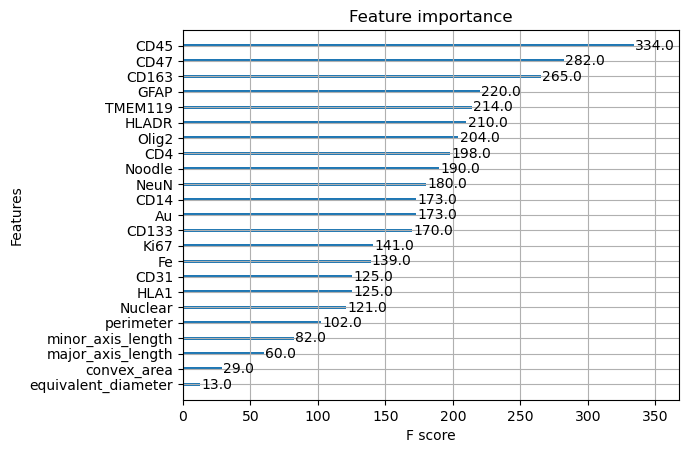

marker name: Arginase1
[0]	validation_0-rmse:0.02564
[1]	validation_0-rmse:0.02414
[2]	validation_0-rmse:0.02286
[3]	validation_0-rmse:0.02172
[4]	validation_0-rmse:0.02077
[5]	validation_0-rmse:0.01991
[6]	validation_0-rmse:0.01918
[7]	validation_0-rmse:0.01849
[8]	validation_0-rmse:0.01793
[9]	validation_0-rmse:0.01744
[10]	validation_0-rmse:0.01701
[11]	validation_0-rmse:0.01661
[12]	validation_0-rmse:0.01632
[13]	validation_0-rmse:0.01604
[14]	validation_0-rmse:0.01580
[15]	validation_0-rmse:0.01555
[16]	validation_0-rmse:0.01537
[17]	validation_0-rmse:0.01520
[18]	validation_0-rmse:0.01508
[19]	validation_0-rmse:0.01496
[20]	validation_0-rmse:0.01486
[21]	validation_0-rmse:0.01475
[22]	validation_0-rmse:0.01465
[23]	validation_0-rmse:0.01459
[24]	validation_0-rmse:0.01450
[25]	validation_0-rmse:0.01445
[26]	validation_0-rmse:0.01440
[27]	validation_0-rmse:0.01437
[28]	validation_0-rmse:0.01434
[29]	validation_0-rmse:0.01430
[30]	validation_0-rmse:0.01426
[31]	validation_0-rmse:0.0

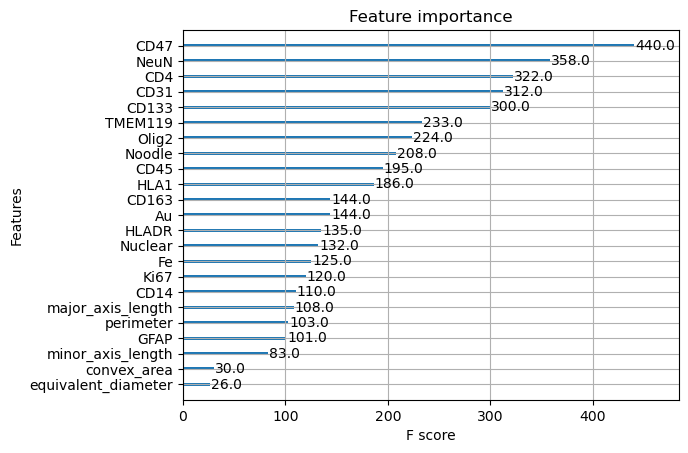

marker name: PD1
[0]	validation_0-rmse:0.03006
[1]	validation_0-rmse:0.02981
[2]	validation_0-rmse:0.02957
[3]	validation_0-rmse:0.02936
[4]	validation_0-rmse:0.02917
[5]	validation_0-rmse:0.02904
[6]	validation_0-rmse:0.02888
[7]	validation_0-rmse:0.02873
[8]	validation_0-rmse:0.02864
[9]	validation_0-rmse:0.02851
[10]	validation_0-rmse:0.02844
[11]	validation_0-rmse:0.02836
[12]	validation_0-rmse:0.02827
[13]	validation_0-rmse:0.02819
[14]	validation_0-rmse:0.02815
[15]	validation_0-rmse:0.02810
[16]	validation_0-rmse:0.02803
[17]	validation_0-rmse:0.02799
[18]	validation_0-rmse:0.02796
[19]	validation_0-rmse:0.02791
[20]	validation_0-rmse:0.02788
[21]	validation_0-rmse:0.02781
[22]	validation_0-rmse:0.02781
[23]	validation_0-rmse:0.02777
[24]	validation_0-rmse:0.02773
[25]	validation_0-rmse:0.02771
[26]	validation_0-rmse:0.02767
[27]	validation_0-rmse:0.02765
[28]	validation_0-rmse:0.02763
[29]	validation_0-rmse:0.02761
[30]	validation_0-rmse:0.02760
[31]	validation_0-rmse:0.02757
[

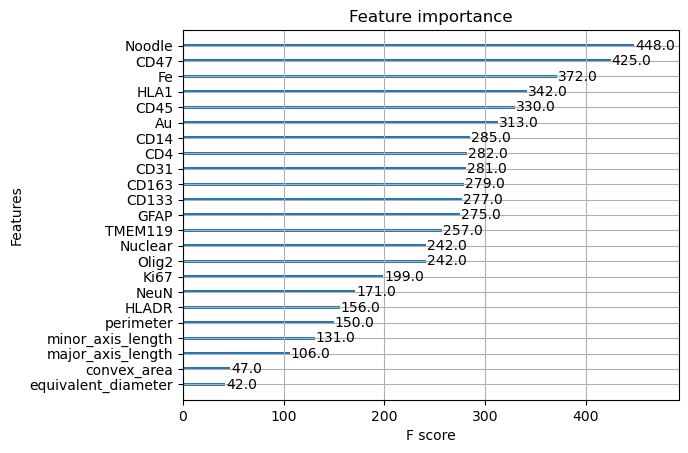

marker name: CD68
[0]	validation_0-rmse:0.02448
[1]	validation_0-rmse:0.02366
[2]	validation_0-rmse:0.02301
[3]	validation_0-rmse:0.02244
[4]	validation_0-rmse:0.02196
[5]	validation_0-rmse:0.02153
[6]	validation_0-rmse:0.02117
[7]	validation_0-rmse:0.02088
[8]	validation_0-rmse:0.02061
[9]	validation_0-rmse:0.02034
[10]	validation_0-rmse:0.02014
[11]	validation_0-rmse:0.01996
[12]	validation_0-rmse:0.01981
[13]	validation_0-rmse:0.01968
[14]	validation_0-rmse:0.01957
[15]	validation_0-rmse:0.01946
[16]	validation_0-rmse:0.01933
[17]	validation_0-rmse:0.01923
[18]	validation_0-rmse:0.01917
[19]	validation_0-rmse:0.01910
[20]	validation_0-rmse:0.01903
[21]	validation_0-rmse:0.01899
[22]	validation_0-rmse:0.01894
[23]	validation_0-rmse:0.01889
[24]	validation_0-rmse:0.01885
[25]	validation_0-rmse:0.01880
[26]	validation_0-rmse:0.01876
[27]	validation_0-rmse:0.01874
[28]	validation_0-rmse:0.01872
[29]	validation_0-rmse:0.01869
[30]	validation_0-rmse:0.01865
[31]	validation_0-rmse:0.01864


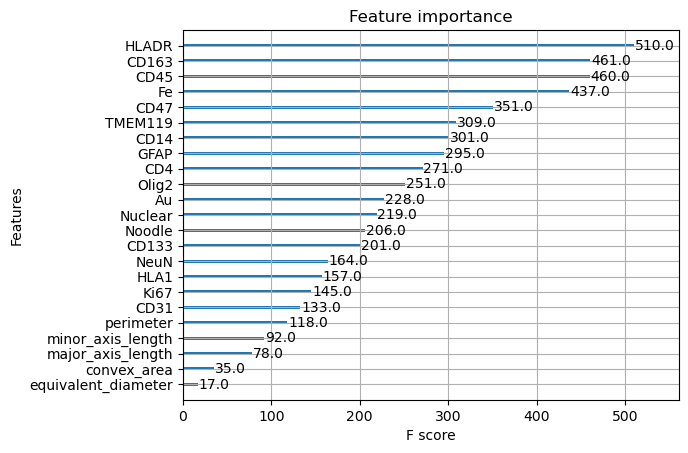

marker name: ICOS
[0]	validation_0-rmse:0.02099
[1]	validation_0-rmse:0.02010
[2]	validation_0-rmse:0.01937
[3]	validation_0-rmse:0.01865
[4]	validation_0-rmse:0.01804
[5]	validation_0-rmse:0.01748
[6]	validation_0-rmse:0.01698
[7]	validation_0-rmse:0.01666
[8]	validation_0-rmse:0.01629
[9]	validation_0-rmse:0.01607
[10]	validation_0-rmse:0.01586
[11]	validation_0-rmse:0.01560
[12]	validation_0-rmse:0.01530
[13]	validation_0-rmse:0.01514
[14]	validation_0-rmse:0.01491
[15]	validation_0-rmse:0.01483
[16]	validation_0-rmse:0.01473
[17]	validation_0-rmse:0.01465
[18]	validation_0-rmse:0.01456
[19]	validation_0-rmse:0.01448
[20]	validation_0-rmse:0.01442
[21]	validation_0-rmse:0.01432
[22]	validation_0-rmse:0.01429
[23]	validation_0-rmse:0.01425
[24]	validation_0-rmse:0.01417
[25]	validation_0-rmse:0.01415
[26]	validation_0-rmse:0.01413
[27]	validation_0-rmse:0.01412
[28]	validation_0-rmse:0.01410
[29]	validation_0-rmse:0.01408
[30]	validation_0-rmse:0.01408
[31]	validation_0-rmse:0.01407


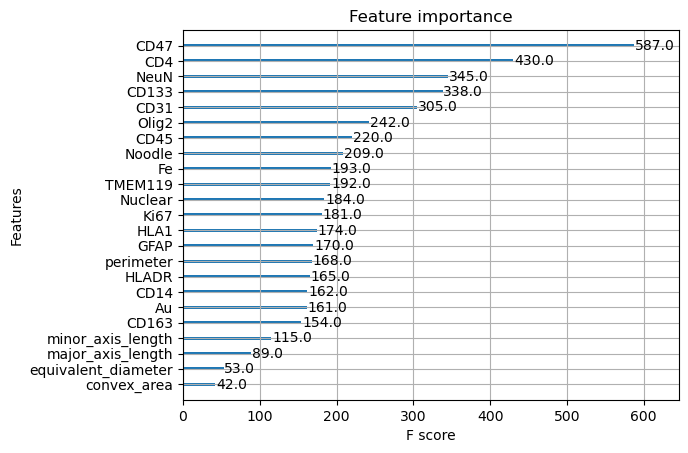

marker name: CD11b
[0]	validation_0-rmse:0.03594
[1]	validation_0-rmse:0.03439
[2]	validation_0-rmse:0.03308
[3]	validation_0-rmse:0.03201
[4]	validation_0-rmse:0.03110
[5]	validation_0-rmse:0.03024
[6]	validation_0-rmse:0.02950
[7]	validation_0-rmse:0.02882
[8]	validation_0-rmse:0.02833
[9]	validation_0-rmse:0.02784
[10]	validation_0-rmse:0.02739
[11]	validation_0-rmse:0.02704
[12]	validation_0-rmse:0.02679
[13]	validation_0-rmse:0.02645
[14]	validation_0-rmse:0.02613
[15]	validation_0-rmse:0.02596
[16]	validation_0-rmse:0.02569
[17]	validation_0-rmse:0.02557
[18]	validation_0-rmse:0.02542
[19]	validation_0-rmse:0.02526
[20]	validation_0-rmse:0.02513
[21]	validation_0-rmse:0.02506
[22]	validation_0-rmse:0.02500
[23]	validation_0-rmse:0.02494
[24]	validation_0-rmse:0.02487
[25]	validation_0-rmse:0.02480
[26]	validation_0-rmse:0.02473
[27]	validation_0-rmse:0.02470
[28]	validation_0-rmse:0.02467
[29]	validation_0-rmse:0.02462
[30]	validation_0-rmse:0.02460
[31]	validation_0-rmse:0.02452

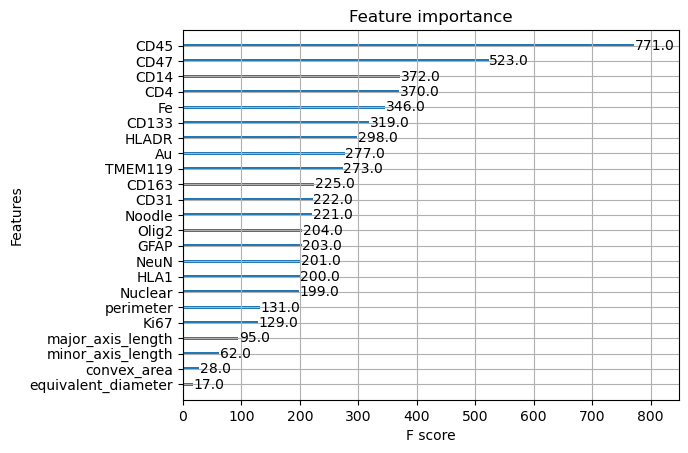

marker name: Tox
[0]	validation_0-rmse:0.01518
[1]	validation_0-rmse:0.01472
[2]	validation_0-rmse:0.01436
[3]	validation_0-rmse:0.01409
[4]	validation_0-rmse:0.01382
[5]	validation_0-rmse:0.01364
[6]	validation_0-rmse:0.01345
[7]	validation_0-rmse:0.01332
[8]	validation_0-rmse:0.01320
[9]	validation_0-rmse:0.01308
[10]	validation_0-rmse:0.01300
[11]	validation_0-rmse:0.01292
[12]	validation_0-rmse:0.01286
[13]	validation_0-rmse:0.01279
[14]	validation_0-rmse:0.01274
[15]	validation_0-rmse:0.01270
[16]	validation_0-rmse:0.01265
[17]	validation_0-rmse:0.01263
[18]	validation_0-rmse:0.01257
[19]	validation_0-rmse:0.01252
[20]	validation_0-rmse:0.01249
[21]	validation_0-rmse:0.01247
[22]	validation_0-rmse:0.01244
[23]	validation_0-rmse:0.01242
[24]	validation_0-rmse:0.01240
[25]	validation_0-rmse:0.01238
[26]	validation_0-rmse:0.01237
[27]	validation_0-rmse:0.01236
[28]	validation_0-rmse:0.01235
[29]	validation_0-rmse:0.01233
[30]	validation_0-rmse:0.01232
[31]	validation_0-rmse:0.01231
[

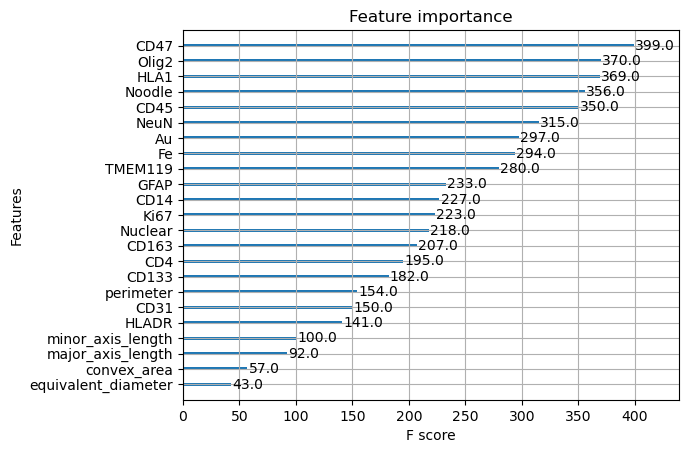

marker name: CD206
[0]	validation_0-rmse:0.02277
[1]	validation_0-rmse:0.02159
[2]	validation_0-rmse:0.02057
[3]	validation_0-rmse:0.01965
[4]	validation_0-rmse:0.01885
[5]	validation_0-rmse:0.01816
[6]	validation_0-rmse:0.01754
[7]	validation_0-rmse:0.01700
[8]	validation_0-rmse:0.01649
[9]	validation_0-rmse:0.01608
[10]	validation_0-rmse:0.01570
[11]	validation_0-rmse:0.01539
[12]	validation_0-rmse:0.01514
[13]	validation_0-rmse:0.01493
[14]	validation_0-rmse:0.01477
[15]	validation_0-rmse:0.01459
[16]	validation_0-rmse:0.01449
[17]	validation_0-rmse:0.01432
[18]	validation_0-rmse:0.01420
[19]	validation_0-rmse:0.01409
[20]	validation_0-rmse:0.01397
[21]	validation_0-rmse:0.01391
[22]	validation_0-rmse:0.01381
[23]	validation_0-rmse:0.01373
[24]	validation_0-rmse:0.01367
[25]	validation_0-rmse:0.01361
[26]	validation_0-rmse:0.01357
[27]	validation_0-rmse:0.01352
[28]	validation_0-rmse:0.01345
[29]	validation_0-rmse:0.01341
[30]	validation_0-rmse:0.01338
[31]	validation_0-rmse:0.01336

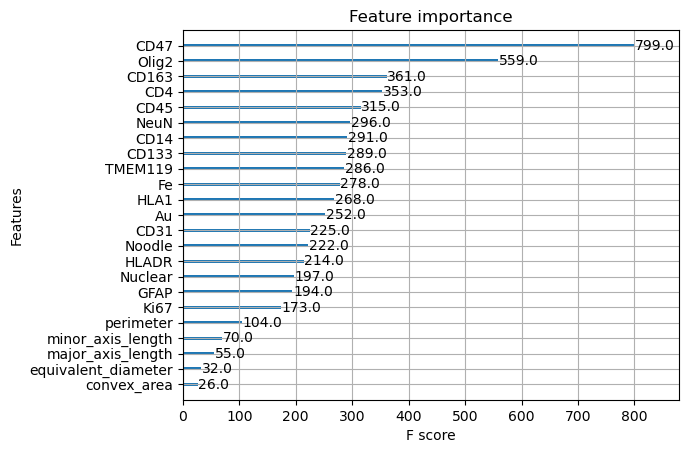

marker name: iNOS
[0]	validation_0-rmse:0.01063
[1]	validation_0-rmse:0.01032
[2]	validation_0-rmse:0.01002
[3]	validation_0-rmse:0.00979
[4]	validation_0-rmse:0.00961
[5]	validation_0-rmse:0.00944
[6]	validation_0-rmse:0.00933
[7]	validation_0-rmse:0.00922
[8]	validation_0-rmse:0.00914
[9]	validation_0-rmse:0.00902
[10]	validation_0-rmse:0.00896
[11]	validation_0-rmse:0.00888
[12]	validation_0-rmse:0.00883
[13]	validation_0-rmse:0.00874
[14]	validation_0-rmse:0.00869
[15]	validation_0-rmse:0.00865
[16]	validation_0-rmse:0.00860
[17]	validation_0-rmse:0.00857
[18]	validation_0-rmse:0.00854
[19]	validation_0-rmse:0.00850
[20]	validation_0-rmse:0.00847
[21]	validation_0-rmse:0.00844
[22]	validation_0-rmse:0.00841
[23]	validation_0-rmse:0.00840
[24]	validation_0-rmse:0.00839
[25]	validation_0-rmse:0.00839
[26]	validation_0-rmse:0.00837
[27]	validation_0-rmse:0.00836
[28]	validation_0-rmse:0.00834
[29]	validation_0-rmse:0.00833
[30]	validation_0-rmse:0.00832
[31]	validation_0-rmse:0.00830


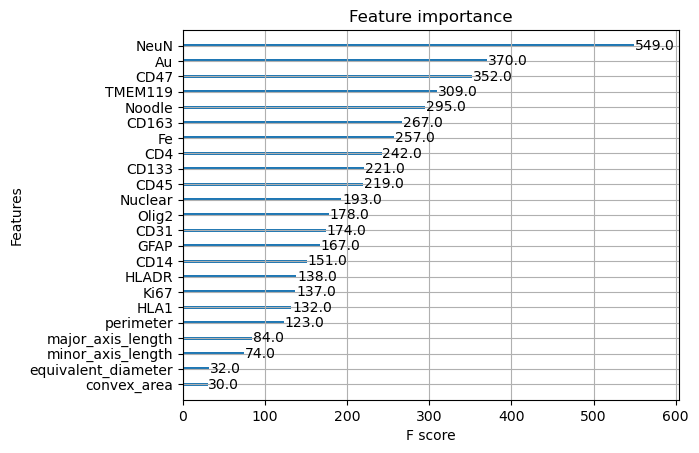

marker name: CD38
[0]	validation_0-rmse:0.02334
[1]	validation_0-rmse:0.02273
[2]	validation_0-rmse:0.02224
[3]	validation_0-rmse:0.02179
[4]	validation_0-rmse:0.02143
[5]	validation_0-rmse:0.02112
[6]	validation_0-rmse:0.02083
[7]	validation_0-rmse:0.02059
[8]	validation_0-rmse:0.02038
[9]	validation_0-rmse:0.02016
[10]	validation_0-rmse:0.02000
[11]	validation_0-rmse:0.01986
[12]	validation_0-rmse:0.01971
[13]	validation_0-rmse:0.01959
[14]	validation_0-rmse:0.01951
[15]	validation_0-rmse:0.01942
[16]	validation_0-rmse:0.01931
[17]	validation_0-rmse:0.01924
[18]	validation_0-rmse:0.01912
[19]	validation_0-rmse:0.01906
[20]	validation_0-rmse:0.01898
[21]	validation_0-rmse:0.01893
[22]	validation_0-rmse:0.01888
[23]	validation_0-rmse:0.01881
[24]	validation_0-rmse:0.01877
[25]	validation_0-rmse:0.01874
[26]	validation_0-rmse:0.01868
[27]	validation_0-rmse:0.01864
[28]	validation_0-rmse:0.01861
[29]	validation_0-rmse:0.01858
[30]	validation_0-rmse:0.01854
[31]	validation_0-rmse:0.01852


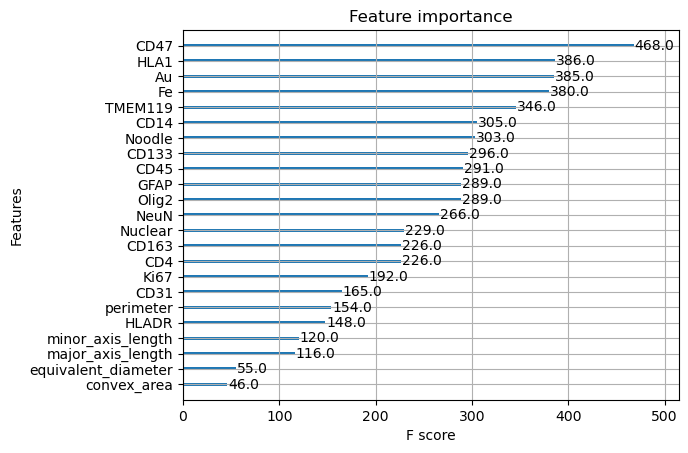

marker name: CD3
[0]	validation_0-rmse:0.01386
[1]	validation_0-rmse:0.01335
[2]	validation_0-rmse:0.01290
[3]	validation_0-rmse:0.01253
[4]	validation_0-rmse:0.01221
[5]	validation_0-rmse:0.01195
[6]	validation_0-rmse:0.01173
[7]	validation_0-rmse:0.01150
[8]	validation_0-rmse:0.01135
[9]	validation_0-rmse:0.01118
[10]	validation_0-rmse:0.01104
[11]	validation_0-rmse:0.01092
[12]	validation_0-rmse:0.01085
[13]	validation_0-rmse:0.01076
[14]	validation_0-rmse:0.01069
[15]	validation_0-rmse:0.01063
[16]	validation_0-rmse:0.01061
[17]	validation_0-rmse:0.01057
[18]	validation_0-rmse:0.01054
[19]	validation_0-rmse:0.01051
[20]	validation_0-rmse:0.01048
[21]	validation_0-rmse:0.01049
[22]	validation_0-rmse:0.01047
[23]	validation_0-rmse:0.01048
[24]	validation_0-rmse:0.01047
[25]	validation_0-rmse:0.01048
[26]	validation_0-rmse:0.01048
[27]	validation_0-rmse:0.01048
[28]	validation_0-rmse:0.01048
[29]	validation_0-rmse:0.01050
[30]	validation_0-rmse:0.01050
[31]	validation_0-rmse:0.01049
P

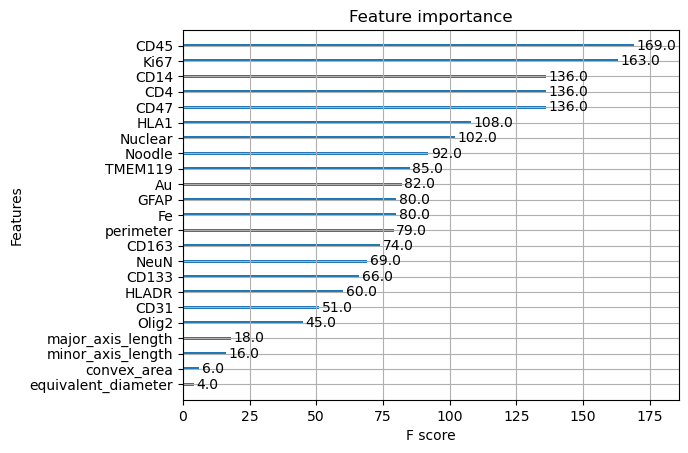

marker name: TIM3
[0]	validation_0-rmse:0.03117
[1]	validation_0-rmse:0.03020
[2]	validation_0-rmse:0.02935
[3]	validation_0-rmse:0.02860
[4]	validation_0-rmse:0.02797
[5]	validation_0-rmse:0.02744
[6]	validation_0-rmse:0.02698
[7]	validation_0-rmse:0.02658
[8]	validation_0-rmse:0.02628
[9]	validation_0-rmse:0.02600
[10]	validation_0-rmse:0.02575
[11]	validation_0-rmse:0.02552
[12]	validation_0-rmse:0.02534
[13]	validation_0-rmse:0.02519
[14]	validation_0-rmse:0.02506
[15]	validation_0-rmse:0.02495
[16]	validation_0-rmse:0.02484
[17]	validation_0-rmse:0.02472
[18]	validation_0-rmse:0.02462
[19]	validation_0-rmse:0.02453
[20]	validation_0-rmse:0.02445
[21]	validation_0-rmse:0.02438
[22]	validation_0-rmse:0.02429
[23]	validation_0-rmse:0.02420
[24]	validation_0-rmse:0.02414
[25]	validation_0-rmse:0.02408
[26]	validation_0-rmse:0.02404
[27]	validation_0-rmse:0.02398
[28]	validation_0-rmse:0.02393
[29]	validation_0-rmse:0.02391
[30]	validation_0-rmse:0.02386
[31]	validation_0-rmse:0.02383


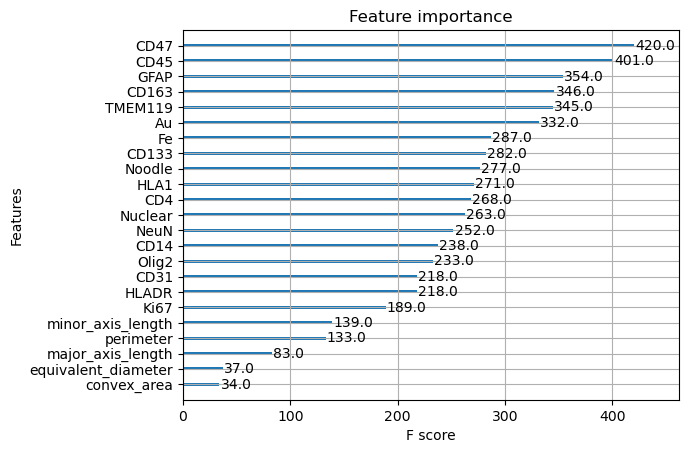

marker name: CD86
[0]	validation_0-rmse:0.03725
[1]	validation_0-rmse:0.03608
[2]	validation_0-rmse:0.03506
[3]	validation_0-rmse:0.03421
[4]	validation_0-rmse:0.03349
[5]	validation_0-rmse:0.03285
[6]	validation_0-rmse:0.03232
[7]	validation_0-rmse:0.03182
[8]	validation_0-rmse:0.03137
[9]	validation_0-rmse:0.03101
[10]	validation_0-rmse:0.03070
[11]	validation_0-rmse:0.03045
[12]	validation_0-rmse:0.03022
[13]	validation_0-rmse:0.03005
[14]	validation_0-rmse:0.02989
[15]	validation_0-rmse:0.02973
[16]	validation_0-rmse:0.02958
[17]	validation_0-rmse:0.02946
[18]	validation_0-rmse:0.02934
[19]	validation_0-rmse:0.02924
[20]	validation_0-rmse:0.02916
[21]	validation_0-rmse:0.02904
[22]	validation_0-rmse:0.02898
[23]	validation_0-rmse:0.02892
[24]	validation_0-rmse:0.02884
[25]	validation_0-rmse:0.02879
[26]	validation_0-rmse:0.02874
[27]	validation_0-rmse:0.02870
[28]	validation_0-rmse:0.02867
[29]	validation_0-rmse:0.02863
[30]	validation_0-rmse:0.02860
[31]	validation_0-rmse:0.02858


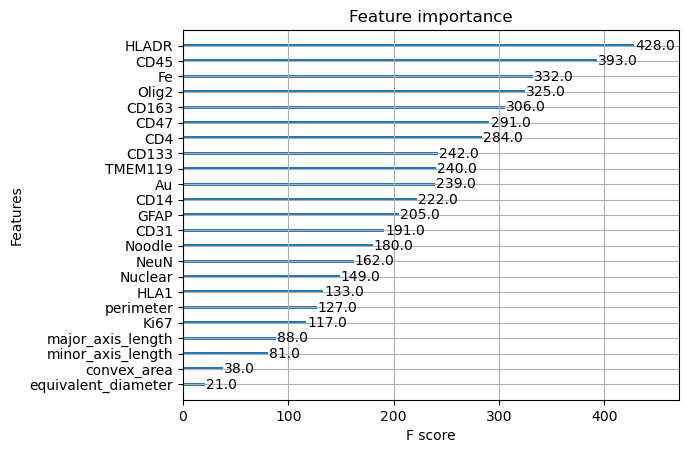

marker name: CD208
[0]	validation_0-rmse:0.01647
[1]	validation_0-rmse:0.01604
[2]	validation_0-rmse:0.01567
[3]	validation_0-rmse:0.01539
[4]	validation_0-rmse:0.01514
[5]	validation_0-rmse:0.01491
[6]	validation_0-rmse:0.01468
[7]	validation_0-rmse:0.01453
[8]	validation_0-rmse:0.01435
[9]	validation_0-rmse:0.01420
[10]	validation_0-rmse:0.01408
[11]	validation_0-rmse:0.01399
[12]	validation_0-rmse:0.01388
[13]	validation_0-rmse:0.01383
[14]	validation_0-rmse:0.01374
[15]	validation_0-rmse:0.01370
[16]	validation_0-rmse:0.01367
[17]	validation_0-rmse:0.01362
[18]	validation_0-rmse:0.01358
[19]	validation_0-rmse:0.01356
[20]	validation_0-rmse:0.01354
[21]	validation_0-rmse:0.01352
[22]	validation_0-rmse:0.01350
[23]	validation_0-rmse:0.01347
[24]	validation_0-rmse:0.01345
[25]	validation_0-rmse:0.01343
[26]	validation_0-rmse:0.01343
[27]	validation_0-rmse:0.01342
[28]	validation_0-rmse:0.01341
[29]	validation_0-rmse:0.01342
[30]	validation_0-rmse:0.01342
[31]	validation_0-rmse:0.01340

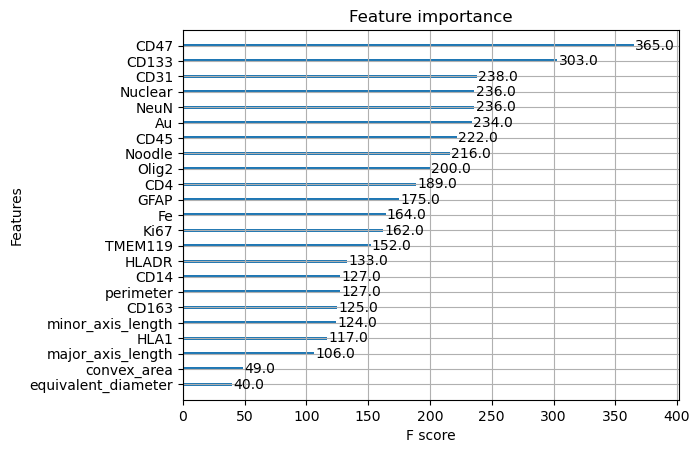

marker name: GLUT1
[0]	validation_0-rmse:0.03106
[1]	validation_0-rmse:0.03064
[2]	validation_0-rmse:0.03028
[3]	validation_0-rmse:0.02983
[4]	validation_0-rmse:0.02955
[5]	validation_0-rmse:0.02931
[6]	validation_0-rmse:0.02907
[7]	validation_0-rmse:0.02889
[8]	validation_0-rmse:0.02868
[9]	validation_0-rmse:0.02841
[10]	validation_0-rmse:0.02821
[11]	validation_0-rmse:0.02801
[12]	validation_0-rmse:0.02781
[13]	validation_0-rmse:0.02768
[14]	validation_0-rmse:0.02751
[15]	validation_0-rmse:0.02734
[16]	validation_0-rmse:0.02720
[17]	validation_0-rmse:0.02705
[18]	validation_0-rmse:0.02696
[19]	validation_0-rmse:0.02684
[20]	validation_0-rmse:0.02673
[21]	validation_0-rmse:0.02665
[22]	validation_0-rmse:0.02658
[23]	validation_0-rmse:0.02652
[24]	validation_0-rmse:0.02644
[25]	validation_0-rmse:0.02638
[26]	validation_0-rmse:0.02632
[27]	validation_0-rmse:0.02624
[28]	validation_0-rmse:0.02618
[29]	validation_0-rmse:0.02613
[30]	validation_0-rmse:0.02607
[31]	validation_0-rmse:0.02603

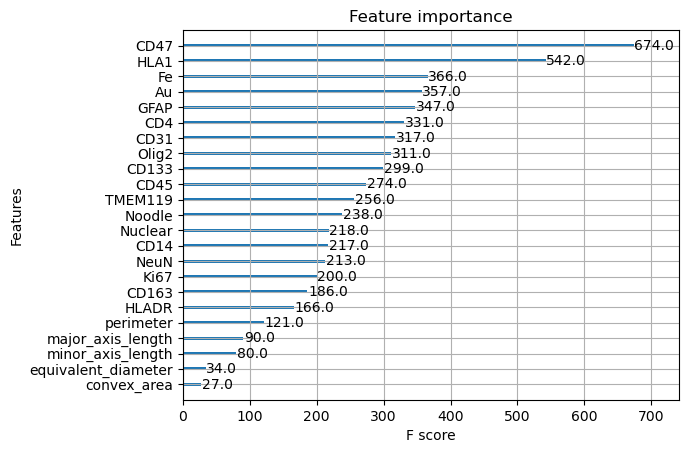

marker name: LAG3
[0]	validation_0-rmse:0.01448
[1]	validation_0-rmse:0.01391
[2]	validation_0-rmse:0.01350
[3]	validation_0-rmse:0.01304
[4]	validation_0-rmse:0.01268
[5]	validation_0-rmse:0.01242
[6]	validation_0-rmse:0.01214
[7]	validation_0-rmse:0.01192
[8]	validation_0-rmse:0.01165
[9]	validation_0-rmse:0.01146
[10]	validation_0-rmse:0.01128
[11]	validation_0-rmse:0.01113
[12]	validation_0-rmse:0.01100
[13]	validation_0-rmse:0.01089
[14]	validation_0-rmse:0.01078
[15]	validation_0-rmse:0.01065
[16]	validation_0-rmse:0.01058
[17]	validation_0-rmse:0.01050
[18]	validation_0-rmse:0.01042
[19]	validation_0-rmse:0.01035
[20]	validation_0-rmse:0.01030
[21]	validation_0-rmse:0.01027
[22]	validation_0-rmse:0.01020
[23]	validation_0-rmse:0.01015
[24]	validation_0-rmse:0.01012
[25]	validation_0-rmse:0.01008
[26]	validation_0-rmse:0.01005
[27]	validation_0-rmse:0.01004
[28]	validation_0-rmse:0.00998
[29]	validation_0-rmse:0.00996
[30]	validation_0-rmse:0.00994
[31]	validation_0-rmse:0.00992


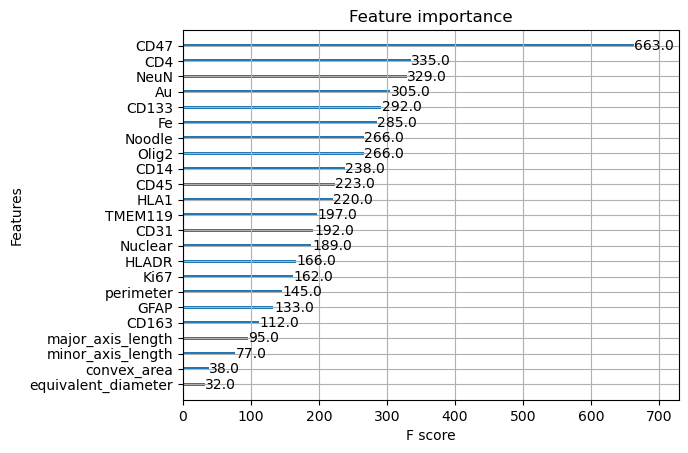

marker name: CD123
[0]	validation_0-rmse:0.02631
[1]	validation_0-rmse:0.02484
[2]	validation_0-rmse:0.02360
[3]	validation_0-rmse:0.02246
[4]	validation_0-rmse:0.02153
[5]	validation_0-rmse:0.02068
[6]	validation_0-rmse:0.02005
[7]	validation_0-rmse:0.01935
[8]	validation_0-rmse:0.01888
[9]	validation_0-rmse:0.01841
[10]	validation_0-rmse:0.01794
[11]	validation_0-rmse:0.01763
[12]	validation_0-rmse:0.01734
[13]	validation_0-rmse:0.01704
[14]	validation_0-rmse:0.01679
[15]	validation_0-rmse:0.01657
[16]	validation_0-rmse:0.01640
[17]	validation_0-rmse:0.01623
[18]	validation_0-rmse:0.01609
[19]	validation_0-rmse:0.01594
[20]	validation_0-rmse:0.01581
[21]	validation_0-rmse:0.01568
[22]	validation_0-rmse:0.01558
[23]	validation_0-rmse:0.01547
[24]	validation_0-rmse:0.01540
[25]	validation_0-rmse:0.01534
[26]	validation_0-rmse:0.01527
[27]	validation_0-rmse:0.01520
[28]	validation_0-rmse:0.01518
[29]	validation_0-rmse:0.01513
[30]	validation_0-rmse:0.01508
[31]	validation_0-rmse:0.01503

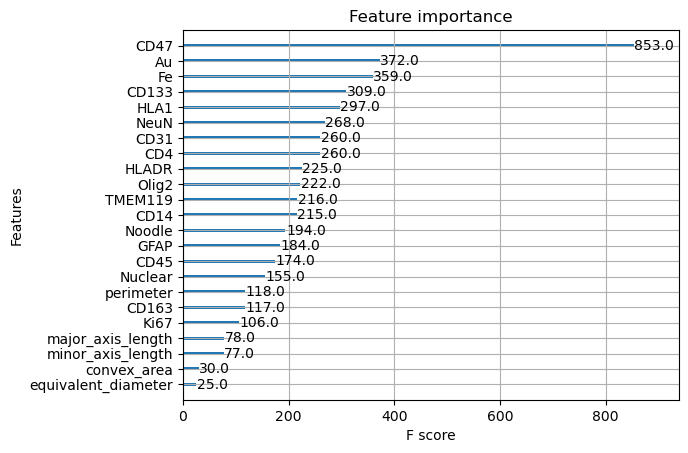

marker name: Chym_Tryp
[0]	validation_0-rmse:0.02016
[1]	validation_0-rmse:0.02006
[2]	validation_0-rmse:0.01992
[3]	validation_0-rmse:0.01985
[4]	validation_0-rmse:0.01981
[5]	validation_0-rmse:0.01970
[6]	validation_0-rmse:0.01961
[7]	validation_0-rmse:0.01949
[8]	validation_0-rmse:0.01939
[9]	validation_0-rmse:0.01932
[10]	validation_0-rmse:0.01930
[11]	validation_0-rmse:0.01924
[12]	validation_0-rmse:0.01921
[13]	validation_0-rmse:0.01920
[14]	validation_0-rmse:0.01916
[15]	validation_0-rmse:0.01914
[16]	validation_0-rmse:0.01912
[17]	validation_0-rmse:0.01910
[18]	validation_0-rmse:0.01902
[19]	validation_0-rmse:0.01899
[20]	validation_0-rmse:0.01897
[21]	validation_0-rmse:0.01896
[22]	validation_0-rmse:0.01895
[23]	validation_0-rmse:0.01895
[24]	validation_0-rmse:0.01892
[25]	validation_0-rmse:0.01890
[26]	validation_0-rmse:0.01889
[27]	validation_0-rmse:0.01887
[28]	validation_0-rmse:0.01887
[29]	validation_0-rmse:0.01881
[30]	validation_0-rmse:0.01881
[31]	validation_0-rmse:0.0

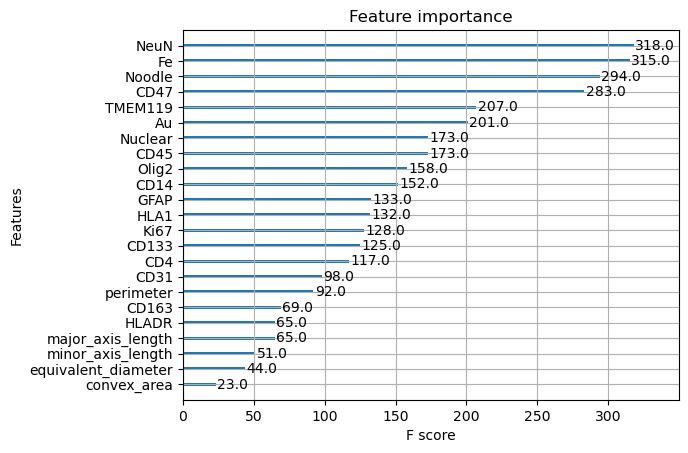

Mean Squared Error: 0.0003


In [154]:
# Initialize a list to store the trained models
models = []
preds = pd.DataFrame()
preds_on_2 = pd.DataFrame()

# Loop through each target variable
for i in range(y_train.shape[1]):
    # Select the current target variable
    marker_name = y_train.columns[i] + "_pred"
    print("marker name:", y_train.columns[i])
    y_train_i = y_train.iloc[:, i]

    # Initialize an XGBRegressor for the current target
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, early_stopping_rounds=10)

    # Fit the XGBRegressor on the training data for the current target
    model.fit(X_train, y_train_i, eval_set=[(X_val, y_val.iloc[:, i])])

    # Get individual metrices 
    y_test_i = y_test.iloc[:, i]
    y_pred_i = model.predict(X_test)
    mse_i = mean_squared_error(y_test_i, y_pred_i)
    ppc = np.corrcoef(y_test_i, y_pred_i)[0, 1]
    print(f"Pearson Correlation Coefficient: {ppc:.4f}")
    print(f"Mean Squared Error: {mse_i:.4f}")

    # Append the y_pred_i to a df 
    preds[marker_name] = y_pred_i

    # Get the feature importance for the current target
    features = model.get_booster().feature_names
    importances = model.feature_importances_
    
    # plot the feature importance plot with feature names
    from xgboost import plot_importance
    import matplotlib.pyplot as plt
    plot_importance(model, importance_type='weight')
    plt.show()

    # Predict the current target variable using the trained model
    y_pred_i2 = model.predict(X2)
    preds_on_2[marker_name] = y_pred_i2 
    #assign the same index as X2
    preds_on_2.index = X2.index

    # Append the trained model to the list of models
    models.append(model)

# Make predictions by predicting each target separately using the corresponding model
y_pred = np.column_stack([model.predict(X_test) for model in models])

# Evaluate the overall performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

In [155]:
# concat the X2 and preds_on_2 by index
print(X2.shape)
print(preds_on_2.shape)

# combine the two dataframes by index cellid
combined = pd.concat([X2, preds_on_2], axis=1)
print(combined.shape)

(90328, 24)
(90328, 29)
(90328, 53)


In [157]:
# concat the X2 and preds_on_2 by index
final_preds = pd.concat([X2, preds_on_2], axis=1)
print(final_preds.shape)

# Save the final_preds to a csv file
final_preds.to_csv("out/final_preds_on_2.csv", index=False)

# concat the tumor meta and final preds
final_preds_with_meta = pd.concat([tumor_meta, final_preds], axis=1)
print(final_preds_with_meta.shape)
# Save the final_preds_with_meta to a csv file
final_preds_with_meta.to_csv("out/final_preds_with_meta.csv", index=False)

(90328, 53)
(90328, 56)


In [167]:
# combine the immune_meta with immune_data
immune_data_with_meta = pd.concat([immune_meta, immune_data], axis=1)
immune_data_with_meta.shape

(90355, 56)

In [178]:
final_preds_with_meta["fov"].value_counts()

fov
Stanford_TA552_R4C1     5864
Stanford_TA552_R5C1     4795
Stanford_TA552_R3C4     4710
Stanford_TA551_R5C3     4529
Stanford_TA552_R10C4    4161
Stanford_TA551_R6C3     4006
Stanford_TA551_R1C3     3874
Stanford_TA552_R8C4     3833
Stanford_TA552_R5C2     3686
Stanford_TA552_R9C5     3568
Stanford_TA552_R3C1     3392
Stanford_TA551_R3C3     3307
Stanford_TA551_R2C3     3277
Stanford_TA552_R6C2     3167
Stanford_TA552_R7C1     3080
Stanford_TA552_R4C2     2845
Stanford_TA551_R9C5     2803
Stanford_TA552_R3C2     2784
Stanford_TA551_R1C4     2715
Stanford_TA552_R7C4     2632
Stanford_TA552_R9C4     2550
Stanford_TA552_R1C4     2526
Stanford_TA551_R4C3     1987
Stanford_TA552_R2C4     1961
Stanford_TA551_R6C4     1848
Stanford_TA552_R6C1     1586
Stanford_TA551_R8C5     1468
Stanford_TA552_R7C2     1288
Stanford_TA552_R8C2      882
Stanford_TA551_R9C3      720
Stanford_TA551_R10C4     484
Name: count, dtype: int64

In [183]:
preds_noindex = pd.read_csv("out/preds_pair.csv")
preds_noindex.columns

immune_orig = pd.read_csv("data/20250203_GBMFOV_immunecelltable.csv")

# combine the preds with immune_orig
immune_orig_preds = pd.concat([immune_orig, preds_noindex], axis=1)

immune_orig_preds.shape



(90355, 87)

(2722, 87)


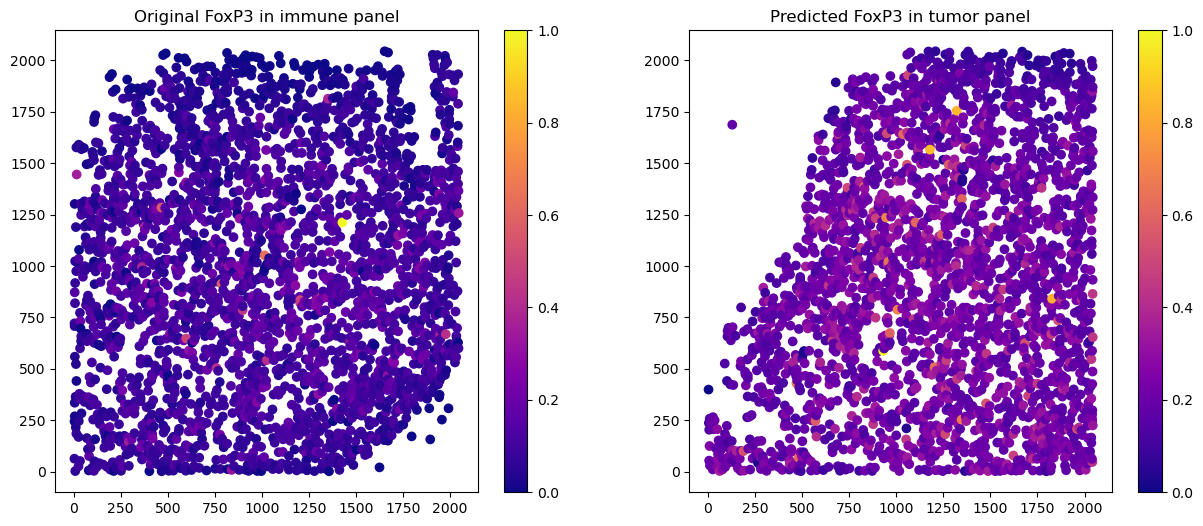

In [198]:
# select rows with fov 1
fov1 = immune_orig_preds[immune_orig_preds["fov"] == "Stanford_TA552_R9C4"]
print(fov1.shape)

fov2 = final_preds_with_meta[final_preds_with_meta["fov"] == "Stanford_TA552_R9C4"]

# take only rows centroid.0 and centroid.1, and cd8_pred
fov1_orig = fov1[["centroid.0","centroid.1","FoxP3"]].copy()
fov1_preds = fov2[["centroid.0","centroid.1","FoxP3_pred"]].copy()

# min max normalise the FoxP3 values
fov1_orig["FoxP3"] = (fov1_orig["FoxP3"] - fov1_orig["FoxP3"].min()) / (fov1_orig["FoxP3"].max() - fov1_orig["FoxP3"].min())
fov1_preds["FoxP3_pred"] = (fov1_preds["FoxP3_pred"] - fov1_preds["FoxP3_pred"].min()) / (fov1_preds["FoxP3_pred"].max() - fov1_preds["FoxP3_pred"].min())

# plot for both the cd8_pred on the centroid.0 and centroid.1
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter0 = axes[0].scatter(fov1_orig["centroid.0"], fov1_orig["centroid.1"], c=fov1_orig["FoxP3"], cmap='plasma') #viridis
axes[0].set_title("Original FoxP3 in immune panel")
fig.colorbar(scatter0, ax=axes[0])

scatter1 = axes[1].scatter(fov1_preds["centroid.0"], fov1_preds["centroid.1"], c=fov1_preds["FoxP3_pred"], cmap='plasma')
axes[1].set_title("Predicted FoxP3 in tumor panel")
fig.colorbar(scatter1, ax=axes[1])

plt.show()



In [223]:
print(preds.shape, y_test.shape)

preds_fox = preds[["FoxP3_pred"]]
y_test_fox = y_test[["FoxP3"]]

# give same index to preds_fox as in y_test_fox
preds_fox.index = y_test_fox.index

#concat preds_fox and y_test_fox by index
combined = pd.concat([y_test_fox, preds_fox], axis=1)
print(combined.columns)

# # Add the fov, centroid.0, centroid.1 to the combined by index
combined = pd.concat([immune_meta, combined], axis=1)

#drop nas
combined = combined.dropna()

(18071, 30) (18071, 30)
Index(['FoxP3', 'FoxP3_pred'], dtype='object')


In [226]:
final_preds_with_meta["fov"].value_counts()

fov
Stanford_TA552_R4C1     5864
Stanford_TA552_R5C1     4795
Stanford_TA552_R3C4     4710
Stanford_TA551_R5C3     4529
Stanford_TA552_R10C4    4161
Stanford_TA551_R6C3     4006
Stanford_TA551_R1C3     3874
Stanford_TA552_R8C4     3833
Stanford_TA552_R5C2     3686
Stanford_TA552_R9C5     3568
Stanford_TA552_R3C1     3392
Stanford_TA551_R3C3     3307
Stanford_TA551_R2C3     3277
Stanford_TA552_R6C2     3167
Stanford_TA552_R7C1     3080
Stanford_TA552_R4C2     2845
Stanford_TA551_R9C5     2803
Stanford_TA552_R3C2     2784
Stanford_TA551_R1C4     2715
Stanford_TA552_R7C4     2632
Stanford_TA552_R9C4     2550
Stanford_TA552_R1C4     2526
Stanford_TA551_R4C3     1987
Stanford_TA552_R2C4     1961
Stanford_TA551_R6C4     1848
Stanford_TA552_R6C1     1586
Stanford_TA551_R8C5     1468
Stanford_TA552_R7C2     1288
Stanford_TA552_R8C2      882
Stanford_TA551_R9C3      720
Stanford_TA551_R10C4     484
Name: count, dtype: int64

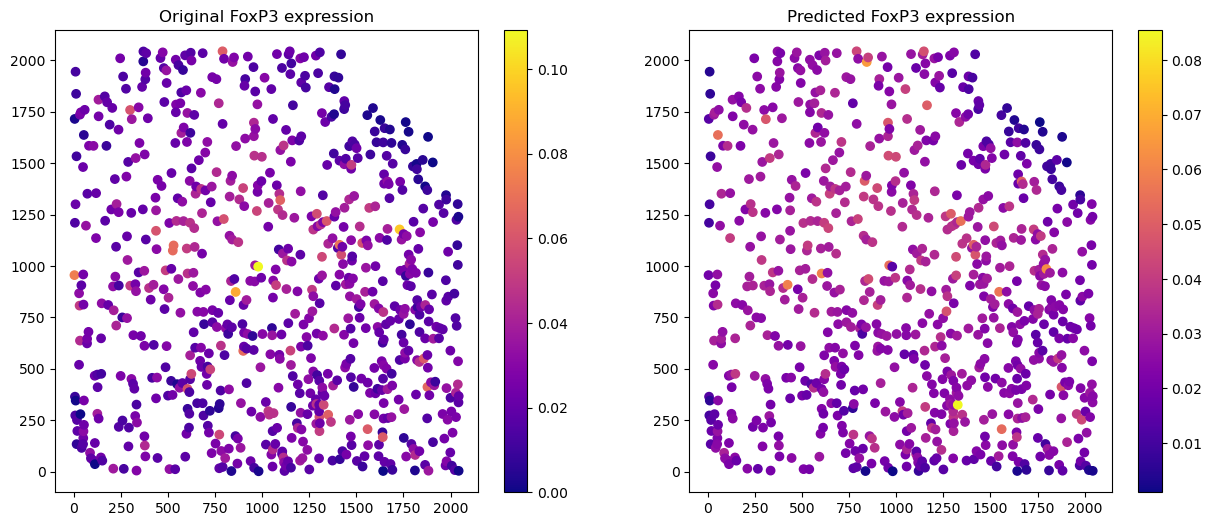

In [230]:
# Select rows with fov 1
roi = combined[combined["fov"] == "Stanford_TA551_R6C3"]

#min max normalise the FoxP3 values and the FoxP3_pred values
#roi["FoxP3"] = (roi["FoxP3"] - roi["FoxP3"].min()) / (roi["FoxP3"].max() - roi["FoxP3"].min())
#
# roi["FoxP3_pred"] = (roi["FoxP3_pred"] - roi["FoxP3_pred"].min()) / (roi["FoxP3_pred"].max() - roi["FoxP3_pred"].min())

# plot foxp3 on the centroid.0 and centroid.1
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter0 = axes[0].scatter(roi["centroid.0"], roi["centroid.1"], c=roi["FoxP3"], cmap='plasma') #viridis
axes[0].set_title("Original FoxP3 expression")
fig.colorbar(scatter0, ax=axes[0])

scatter1 = axes[1].scatter(roi["centroid.0"], roi["centroid.1"], c=roi["FoxP3_pred"], cmap='plasma')
axes[1].set_title("Predicted FoxP3 expression")
fig.colorbar(scatter1, ax=axes[1])

plt.show()


## Correlation-analysis 

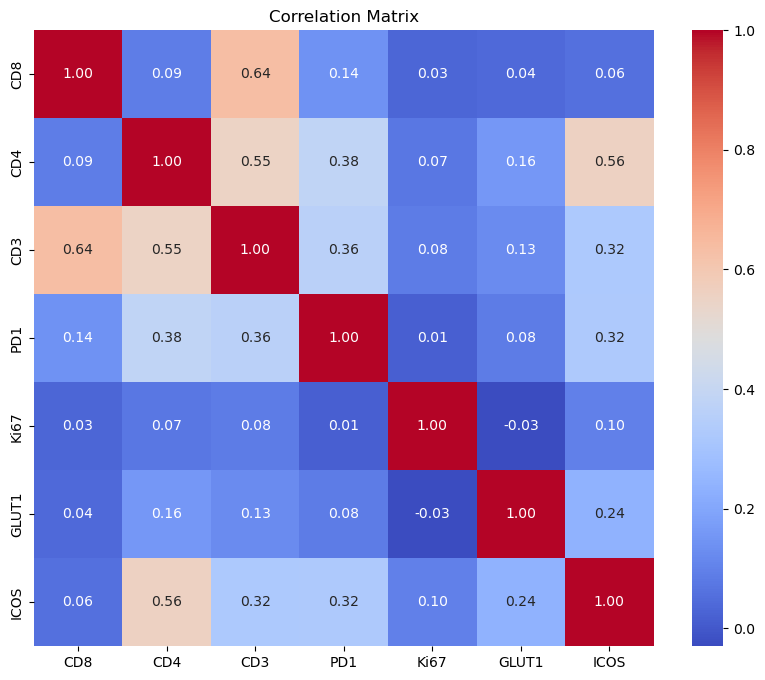

In [79]:
# contact the preds and x_test 
X_test = X_test.reset_index(drop=True)
preds = preds.reset_index(drop=True)
correlation_test = pd.concat([X_test, preds], axis=1)

# Plot a correlation matrix with increased size
import seaborn as sns
import matplotlib.pyplot as plt

# select the columns Inos, cd163
correlation_test = correlation_test[["CD8", "CD4", "CD3", "PD1", "Ki67", "GLUT1","ICOS"]]


#plot correlation matrix that shows positive or negative correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [72]:
from scipy.stats.stats import pearsonr

#calculation correlation coefficient and p-value between x and y
pearsonr(correlation_test["iNOS"], correlation_test["CD163"])


/var/folders/mg/zdym77mj563f5msk4r9jfc480000gn/T/ipykernel_47531/3734356661.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.2256729759184476, pvalue=2.1261879364541237e-207)

In [85]:
immune_data.columns

Index(['Arginase1', 'Au', 'CD11b', 'CD123', 'CD133', 'CD14', 'CD141', 'CD163',
       'CD20', 'CD206', 'CD208', 'CD209', 'CD3', 'CD31', 'CD38', 'CD4', 'CD40',
       'CD45', 'CD47', 'CD68', 'CD8', 'CD86', 'Calprotectin', 'Chym_Tryp',
       'Fe', 'FoxP3', 'GFAP', 'GLUT1', 'HLA1', 'HLADR', 'ICOS', 'IDO1', 'Ki67',
       'LAG3', 'NeuN', 'Noodle', 'Nuclear', 'Olig2', 'PD1', 'PDL1', 'TIM3',
       'TMEM119', 'Tox', 'chan_39', 'chan_48', 'chan_70', 'iNOS', 'area',
       'major_axis_length', 'minor_axis_length', 'perimeter', 'convex_area',
       'equivalent_diameter'],
      dtype='object')

In [103]:
print(immune_data.shape, final_preds.shape)

(90355, 53) (90328, 53)


## Clustering analysis

/Users/arojhada/anaconda3/envs/basic/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/arojhada/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


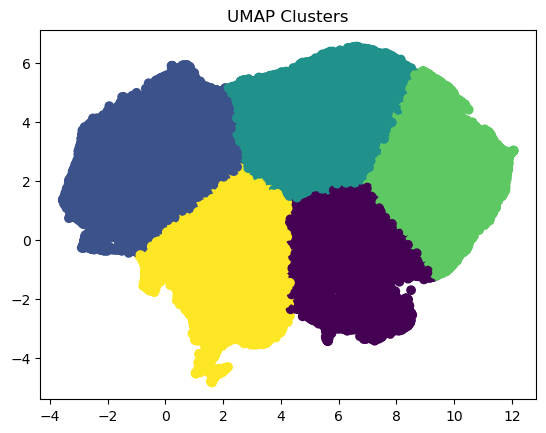

In [109]:
#UMAP clustering of the preds_on_2

import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(immune_data)

kmeans = KMeans(n_clusters=5, random_state=42)
y_umap = kmeans.fit_predict(X_umap)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_umap)
plt.title("UMAP Clusters")
plt.show()


/Users/arojhada/anaconda3/envs/basic/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/arojhada/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


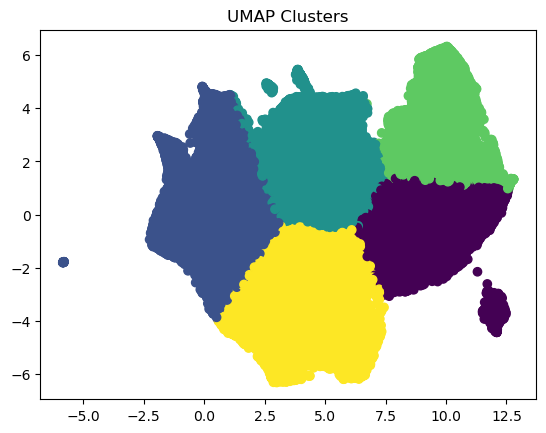

In [110]:
#UMAP clustering of the preds_on_2

import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(final_preds)

kmeans = KMeans(n_clusters=5, random_state=42)
y_umap = kmeans.fit_predict(X_umap)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_umap)
plt.title("UMAP Clusters")
plt.show()

In [112]:
# read the immune data
immune_data_full = pd.read_csv("data/20250203_GBMFOV_immunecelltable.csv")
immune_data_full.columns

Index(['cellid', 'Arginase1', 'Au', 'CD11b', 'CD123', 'CD133', 'CD14', 'CD141',
       'CD163', 'CD20', 'CD206', 'CD208', 'CD209', 'CD3', 'CD31', 'CD38',
       'CD4', 'CD40', 'CD45', 'CD47', 'CD68', 'CD8', 'CD86', 'Calprotectin',
       'Chym_Tryp', 'Fe', 'FoxP3', 'GFAP', 'GLUT1', 'HLA1', 'HLADR', 'ICOS',
       'IDO1', 'Ki67', 'LAG3', 'NeuN', 'Noodle', 'Nuclear', 'Olig2', 'PD1',
       'PDL1', 'TIM3', 'TMEM119', 'Tox', 'chan_39', 'chan_48', 'chan_70',
       'iNOS', 'area', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'convex_area', 'equivalent_diameter', 'centroid.0', 'fov'],
      dtype='object')

In [ ]:
# Assign clusters to the immune data
immune_data_cluster = immune_data_full.copy()
immune_data_cluster["cluster"] = y_umap

# Add the cellid col to immune data
immune_data_cluster["cellid"] = immune_data_full["cellid"]

# Plot by 